## Task 4 - Topic Modelling using LDA

Exploring Topic Modelling using the Latent Dirichlet Allocation Topic Modeller using the Gensim library.

__References__
* Gensim [documentation](https://radimrehurek.com/gensim/models/ldamodel.html)
* TowardsDataScience [blogpost](https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835)


Assumptions:
* __URLs__ would be removed
* __Hashtags__ would be removed
* __Mentions__ would be removed
* __Repeating dots__ (more than two occurences) e.g.: __...__ would be removed
* __Emojis__ would be removed
* __Repeating characters__ (more than two occurences) e.g.: عاااااااجل would be removed
* __Arabic Diacritics__ would be removed
* __Punctuation__ would be removed (only alphanumeric characters)
* __Lemmatization__ would be performed using the Qalsadi lemmatizer

__Stopwords__ would need to be removed in a future step

In [1]:
import pandas as pd
import emoji  # for removing emojis
import pyarabic.araby as araby  # for removing diacritics
import math
import re
import os
import qalsadi.lemmatizer
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pyLDAvis  # For visualizing LDA topics
import pyLDAvis.gensim_models as gensimvis  
from tqdm import tqdm
from camel_tools.tokenizers.word import simple_word_tokenize
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
# For checking appropriate format for LDA Model
from gensim.test.utils import common_corpus, common_texts

/home/tamer/anaconda3/envs/psut-nlp-project/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
qalsadi_lemmatizer = qalsadi.lemmatizer.Lemmatizer()

In [3]:
# From Task1
def clean(sentence):
    """Pre-processes an Arabic sentence for bigram modelling.

    1- Removes URLs, Hashtags, Mentions, and repeating dots.
    2- Removes repeating characters than occur more than twice.
    3- Removes emojis.
    4- Removes Arabic Diacritics.
    5- Removes punctuations and only keeps alphanumeric characters.
    6- Converts sentence to Word Tokens.
    7- Lemmatizes each Token using the Qalsadi Lemmatizer.

    Args:
        sentence (string): Arabic sentence to preprocess.

    Returns:
        sequence (list): processed list of tokens. 
    """
    def _remove_emojis(string):
        return emoji.get_emoji_regexp().sub(u"", string)

    def _remove_diacritics(string):
        return araby.strip_diacritics(string)

    re_general_pattern = r"https?:\/\/.*[\r\n]*|#\w+|@\w+|\.{2,}"
    re_repeating_character_pattern = r"(\w)\1{2,}"

    # 1- Removing URLs, Hashtags, Mentions, and repeating dots
    sentence = re.sub(re_general_pattern, "", sentence)
    # 2- Removing repeating characters that occur more than twice
    sentence = re.sub(re_repeating_character_pattern, r"\1", sentence)
    # 3- Removing emojis
    sentence = _remove_emojis(sentence)
    # 4- Removing arabic diacritics
    sentence = _remove_diacritics(sentence)
    # 5- Tokenization and punctuation removal (only alphanumeric)
    sequence = [token.lower() for token in simple_word_tokenize(sentence) if token.isalpha()]
    # 6- Lemmatization
    sequence = [qalsadi_lemmatizer.lemmatize(token) for token in sequence]

    return sequence

In [4]:
common_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

In [5]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [6]:
Dictionary(common_texts)

In [7]:
dir(Dictionary)

['__abstractmethods__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_adapt_by_suffix',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'add_documents',
 'add_lifecycle_event',
 'compactify',
 'doc2bow',
 'doc2idx',
 'filter_extremes',
 'filter_n_most_frequent',
 'filter_tokens',
 'from_corpus',
 'from_documents',
 'get',
 'items',
 'iteritems',
 'iterkeys',
 'itervalues',
 'keys',
 'load',
 'load_from_text',
 'merge_with',
 'most_common',
 'patch_with_special_tokens',
 'save',
 'save_as_text',
 'values']

### 1- Importing and cleaning the 50,000 arabic tweets data

In [8]:
data_df = pd.read_csv("data/full_data.txt", sep="\t")
data_df.drop("tweetID", axis=1, inplace=True)

In [9]:
data_df

,tweetText
0,حال استنفار قصوى في شمال فرنسا http://t.co/umT...
1,عَمْرُو عبد الهادي الاعلام الصهيوني المصري مش ...
2,عرض فرصه للبيع مزرعه من الوكيل مباشر في الدائر...
3,10 قتلى بانفجارين أحدهما بمسجد شيعي في بغداد h...
4,@teriangle_hd القنابل البدائية مش من مقام فرنس...
...,...
49995,السيادة على مزارع شبعا http://t.co/LaUZcJYZii ...
49996,"#عاجل أوامر ملكية بعد قليل على السعودية الأولى"""
49997,عاجل/ أوامر ملكية بعد قليل على قناة السعودية ا...
49998,#الرياض الميليشيات تبايع نوري المالكي!: الميلي...


In [10]:
# Cleaning texts and appending to texts list
tweets_list = []

for index, tweet in tqdm(data_df.iterrows()):
    tweet = clean(tweet[0])
    tweets_list.append(tweet)

50000it [18:49, 44.28it/s]


In [11]:
tweets_list[0]

['حال', 'استنفار', 'قصوى', 'في', 'شمال', 'فرنسا']

In [12]:
len(tweets_list)

50000

### 2- Preparing the tweets for LDA Topic Modelling

In [14]:
tweet_dictionary = Dictionary(tweets_list)

In [15]:
tweet_dictionary

In [16]:
tweet_corpus = [tweet_dictionary.doc2bow(tweet) for tweet in tweets_list]

In [17]:
tweet_corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

### 3- LDA Topic Modelling

#### 3.1 Calculating coherence scores for multiple LDA models
Reference [blogpost](https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835)

In [18]:
RANDOM_STATE = 420

In [20]:
# compute coherence
tweets_coherence = []

for nb_topics in tqdm(range(1, 51)):
    lda_model = LdaMulticore(
        random_state=RANDOM_STATE,
        corpus=tweet_corpus,
        num_topics=nb_topics,
        id2word=tweet_dictionary,
        iterations=3000,
        workers=os.cpu_count(),  # Number of available CPU cores
        chunksize=2000,
        passes=5,
        batch=False,
        alpha='symmetric',
        decay=0.5,
        offset=1.0,
        eval_every=10,
        gamma_threshold=0.001
    )
    cohm = CoherenceModel(model=lda_model, corpus=tweet_corpus, dictionary=tweet_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

100%|███████████████████████████████████████████| 50/50 [11:48<00:00, 14.18s/it]


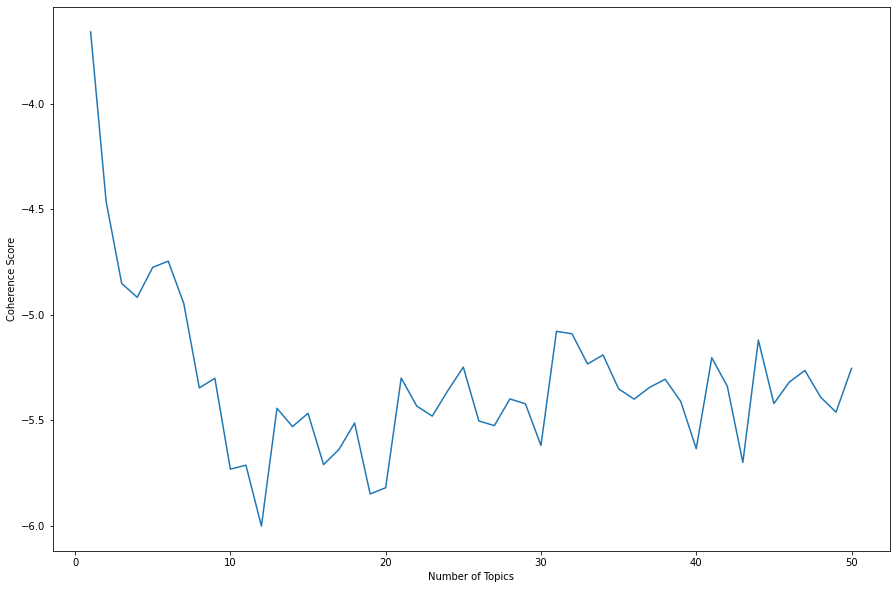

In [21]:
# visualize coherence
plt.figure(figsize=(15, 10))
plt.plot(range(1, 51), tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

### Choosing number of topics = 6
highest points before lower coherence scores afterwards

Tweets are not the most optimal corpus for coherence score calculation

#### 3.2 LDA modeling

In [22]:
NUM_TOPICS = 6

lda_model = LdaMulticore(
    random_state=RANDOM_STATE,
    corpus=tweet_corpus,
    num_topics=NUM_TOPICS,
    id2word=tweet_dictionary,
    iterations=3000,
    workers=os.cpu_count(),  # Number of available CPU cores
    chunksize=2000,
    passes=1,
    batch=False,
    alpha='symmetric',
    decay=0.5,
    offset=1.0,
    eval_every=10,
    gamma_threshold=0.001
)

In [23]:
lda_model

In [24]:
lda_model.show_topics()

[(0,
  '0.062*"في" + 0.013*"تفجير" + 0.010*"من" + 0.009*"الميليشيات" + 0.008*"على" + 0.008*"عن" + 0.008*"الله" + 0.008*"شيع" + 0.007*"فرنسا" + 0.007*"و"'),
 (1,
  '0.035*"على" + 0.035*"في" + 0.017*"هجوم" + 0.014*"من" + 0.010*"مقتل" + 0.010*"قياد" + 0.010*"قاعد" + 0.010*"بعد" + 0.010*"عراق" + 0.009*"وفاة"'),
 (2,
  '0.044*"في" + 0.021*"من" + 0.014*"على" + 0.012*"الله" + 0.011*"منطق" + 0.010*"حزب" + 0.010*"مقتل" + 0.009*"يمن" + 0.009*"لبن" + 0.008*"سعودي"'),
 (3,
  '0.050*"في" + 0.027*"من" + 0.015*"على" + 0.013*"تفجير" + 0.010*"شرطة" + 0.009*"هجوم" + 0.008*"يمن" + 0.008*"عن" + 0.007*"مقتل" + 0.006*"كلية"'),
 (4,
  '0.044*"في" + 0.021*"على" + 0.013*"تفجير" + 0.012*"انتحار" + 0.011*"الله" + 0.011*"من" + 0.010*"بعد" + 0.008*"رئيس" + 0.008*"لبن" + 0.007*"يمن"'),
 (5,
  '0.053*"في" + 0.023*"على" + 0.020*"هجوم" + 0.019*"من" + 0.016*"شارل" + 0.011*"تفجير" + 0.008*"مقتل" + 0.008*"صحيفة" + 0.008*"رئيس" + 0.007*"يمن"')]

In [25]:
# Imported from:
#  https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835

def plot_top_words(lda=lda_model, nb_topics=NUM_TOPICS, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(NUM_TOPICS)) + 1,round(math.sqrt(NUM_TOPICS)) + 1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(25, 20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic " + str(i))
        

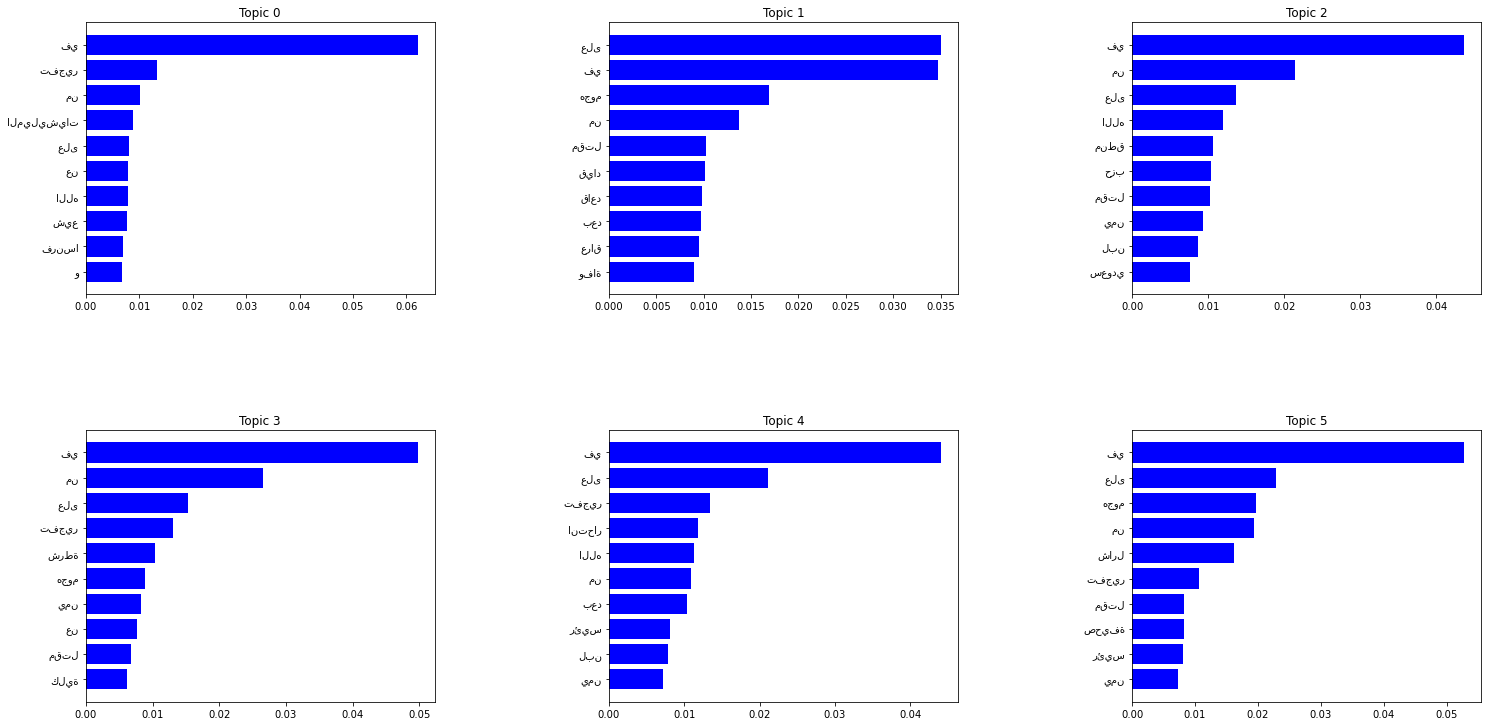

In [26]:
plot_top_words()

#### Trying pyLDAvis
Reference [blogpost](https://dzone.com/articles/topic-modelling-techniques-and-ai-models) [notebook](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=1&lambda=1&term=)

In [27]:
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model, tweet_corpus, tweet_dictionary)

/home/tamer/anaconda3/envs/psut-nlp-project/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.019600 -0.050877       1        1  19.546196
3     -0.006071 -0.047896       2        1  19.061424
1     -0.057606  0.059370       3        1  17.294463
2      0.085656  0.017529       4        1  15.113683
4      0.013680  0.033017       5        1  15.089802
0     -0.016060 -0.011144       6        1  13.894432, topic_info=            Term          Freq         Total Category  logprob  loglift
81          شارل   2939.000000   2939.000000  Default  30.0000  30.0000
8425       اصطدم    628.000000    628.000000  Default  29.0000  29.0000
8478  الميليشيات   1507.000000   1507.000000  Default  28.0000  28.0000
14           على  11758.000000  11758.000000  Default  27.0000  27.0000
2346        وفاة   1356.000000   1356.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
207         مقتل    298.176885   4269.314067   Topic6  -5.6222  -0.6878
661          ملك    255.350800   1666.674348   Topic6  -5.7772   0.0977
81          شارل    269.650303   2939.079647   Topic6  -5.7228  -0.4150
82          هجوم    277.081836   6456.737903   Topic6  -5.6956  -1.1749
47        انتحار    255.534578   2478.184708   Topic6  -5.7765  -0.2982

[543 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1629       1  0.952527      bot
7342       6  0.859655  fanatik
15192      4  0.902878     quds
983        1  0.080318       vs
983        2  0.022948       vs
...      ...       ...      ...
233        4  0.185613      يوم
233        5  0.046515      يوم
233        6  0.129258      يوم
20379      6  0.862264  ﺍﻟﺸﻌﺒﻴﺔ
20380      6  0.862261   ﺍﻟﻠﺠﺎﻥ

[1627 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 2, 3, 5, 1])

#### Stopwords would need to be removed in future steps